# Baselines

## Test
### Motivation

Create a set of baselines for demand prediction using conventional methods:

* time series prediction
* per cell prediction using any type of regressor, e.g. gradient boosting regressor

# Prepare data

In [75]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [129]:
%%time 

raw_data = pd.read_feather('../data/train_data.feather')

print(f'Dataset shape: {raw_data.shape}\n')
raw_data.head(3)

Dataset shape: (41988051, 8)

CPU times: user 2.04 s, sys: 9.23 s, total: 11.3 s
Wall time: 27.3 s


,pickup_datetime,dropoff_datetime,passenger_count,distance,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat
0,2015-01-01 00:00:00,2015-01-01 00:00:00,3,2.510570,-74.001320,40.729057,-74.010208,40.719662
1,2015-01-01 00:00:03,2015-01-01 00:10:50,1,2.542757,-73.987579,40.765270,-73.976921,40.776970
2,2015-01-01 00:00:03,2015-01-01 00:21:48,2,4.136004,-73.969017,40.754269,-73.994133,40.761600


In [130]:
raw_data.drop(['dropoff_datetime', 'passenger_count', 'distance',
           'dropoff_lon', 'dropoff_lat'], axis=1, inplace=True)

raw_data.columns = ['datetime', 'lon', 'lat']

raw_data.head(3)

,datetime,lon,lat
0,2015-01-01 00:00:00,-74.001320,40.729057
1,2015-01-01 00:00:03,-73.987579,40.765270
2,2015-01-01 00:00:03,-73.969017,40.754269


## Limit for a smaller area

Use area selected manually using http://geojson.io/#map=15/40.7357/-73.9889

In [131]:
bbox = ((-73.996, -73.9817), (40.7308, 40.7416))

(min_lon, max_lon), (min_lat, max_lat) = bbox

idx = (data.lat >= min_lat) & (data.lat <= max_lat)
idx = idx & (data.lon >= min_lon) & (data.lon <= max_lon)

print(f'Dataset size: {raw_data.shape[0]}')
print(f'Sample size: {idx.sum()}')

data = raw_data[idx].reset_index(drop=True);

Dataset size: 41988051
Sample size: 2750089


Demand per day stats:

In [132]:
data.datetime.dt.date.value_counts().describe()

count      120.000000
mean     22917.408333
std       3606.016374
min       7588.000000
25%      21055.500000
50%      23054.000000
75%      25072.500000
max      32858.000000
Name: datetime, dtype: float64

## Round time

In [133]:
data.datetime = data.datetime.dt.round('10min')

data.sample(5)

,datetime,lon,lat
580314,2015-01-26 16:00:00,-73.989235,40.734192
776683,2015-02-04 21:30:00,-73.991020,40.737991
1385914,2015-03-01 15:00:00,-73.994812,40.739868
264424,2015-01-13 12:30:00,-73.988190,40.737839
1693652,2015-03-15 03:50:00,-73.985069,40.732456


Create a grid and count the *number of requests per cell*

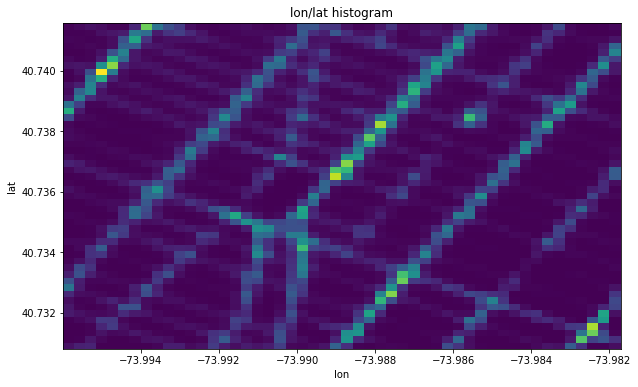

In [138]:
plt.figure(figsize=(10, 6))

plt.hist2d(data.lon, data.lat, bins=50);
plt.title('lon/lat histogram');
plt.xlabel('lon');
plt.ylabel('lat');

## Number of requests per day

In [ ]:
def calc_hist(data, bins, value_range):
    hist, _, _ = np.histogram2d(data.pickup_lon,
                                data.pickup_lat,
                                range=value_range,
                                bins=bins)
    
    return hist.astype(int)

In [ ]:
plt.figure(figsize=(24, 20))

bins = (12, 17)
dates = ['2015-01-15', '2015-01-10', '2015-01-5', '2015-01-1']

for i, date in enumerate(dates):

    plt.subplot(2, 2, i + 1)

    idx = data.pickup_datetime.dt.date == pd.to_datetime(date)    
    hist = calc_hist(data[idx], bins, sample_box)

    print(f'Total on {date}: {int(hist.sum())}')

    plt.title(f'Number of requests on {date}')
    sns.heatmap(np.flip(np.fliplr(hist.T)), annot=True)

plt.subplots_adjust(wspace=0, hspace=0.1)

## Number of requests per hour

In [ ]:
plt.figure(figsize=(24, 20))

bins = (12, 17)
date = '2015-01-15'

# scale font for readability
with sns.plotting_context('paper', font_scale=1.4):
    
    for i, hour in enumerate([6, 10, 16, 19]):

        plt.subplot(2, 2, i + 1)

        idx = (data.pickup_datetime.dt.date == pd.to_datetime(
            date)) & (data.pickup_datetime.dt.hour == hour)
        hist = calc_hist(data[idx], bins, sample_box)

        print(f'Total at {hour}: {int(hist.sum())}')

        plt.title(f'Number of requests at {hour}')
        sns.heatmap(np.flip(np.fliplr(hist.T)), annot=True)

    plt.subplots_adjust(wspace=0, hspace=0.1)

## Create a demand dataset

* remove all data outside of the prediction area
* remove unnecessary columns
* create a grid and map each data point to a cell of the grid

### Demand dataset

In [ ]:
demand_data = data[
    (data.pickup_lon >= sample_box[0][0]) &
    (data.pickup_lon <= sample_box[0][1]) &
    (data.pickup_lat >= sample_box[1][0]) &
    (data.pickup_lat <= sample_box[1][1])
]

demand_data = demand_data[['pickup_datetime', 'pickup_lon', 'pickup_lat']]
demand_data.columns = ['datetime', 'lon', 'lat']

demand_data.datetime = demand_data.datetime.dt.round('30min')

demand_data.head(3)

### Create a grid

In [ ]:
# cell_size x cell_size grid
cell_size = 20

xcells = np.linspace(sample_box[0][0], sample_box[0][1], cell_size)
demand_data['x_cell'] = np.digitize(demand_data.lon, xcells)

ycells = np.linspace(sample_box[1][0], sample_box[1][1], cell_size)
demand_data['y_cell'] = np.digitize(demand_data.lat, ycells)

demand_data['cell'] = demand_data.apply(
    lambda item: '{}-{}'.format(item.x_cell, item.y_cell), axis=1)

demand_data.head(5)

## Remove noise

It doesn't make sense to predict demand in cells with very low number of requests. The question what level of demand is *low*?

From a business point of view, for example a taxi company, it is important to predict locations and level of high demand, not areas with few requests per day.

In [ ]:
plt.figure(figsize=(20, 7))

date = pd.to_datetime('2015-01-09')
idx = demand_data.datetime.dt.date == date

agg_demand = demand_data[idx].groupby('cell').cell.count()

plt.subplot(121)
plt.title(f'Requests per cell on {date}')
plt.hist(agg_demand, bins=100)
plt.xlabel('Num requests')

plt.subplot(122)
plt.boxplot(agg_demand, meanline=True)
plt.title(f'Requests on {date}')
plt.ylabel('Num requests');

Detect areas with high demand per day, check how demand changes in those areas during some period of time

In [ ]:
agg_demand.describe()

In [ ]:
plt.hist(demand_data.groupby(['datetime', 'cell']).cell.count(), bins=50);